Лабораторная работа 4. Кластеризация

Цель работы: изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

Задачи:

1. Загрузить датасет для задачи кластеризации. Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы), провести анализ выбросов.

2. Выполнить стандартизацию/нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных и предположительного количества кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя или анализа силуэта.

4. Рассчитать метрики качества для обоих методов. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Провести сравнительный анализ решений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости), визуализировать диаграмму рассеивания с выделенными кластерами. Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные разными методами.

Выбранный датасет: Stellar Classification Dataset: Классификация звёзд, галактик и квазаров. <br> <br>
Описание датасета: данные состоят из 100000 наблюдений за космосом, сделанных в рамках проекта SDSS (Sloan Digital Sky Survey). Каждое наблюдение описывается 17 столбцами с характеристиками и 1 столбцом с классом, который определяет, является ли объект звездой, галактикой или квазаром.

Столбцы в датасете: <br>
obj_ID = идентификатор объекта, уникальное значение, которое идентифицирует объект в каталоге изображений, используемом CAS <br>
alpha = угол прямого восхождения (в эпоху J2000) <br>
delta = угол склонения (в эпоху J2000) <br>
u = ультрафиолетовый фильтр в фотометрической системе <br>
g = зелёный фильтр в фотометрической системе<br>
r = красный фильтр в фотометрической системе<br>
i = фильтр ближнего инфракрасного диапазона в фотометрической системе<br>
z = инфракрасный фильтр в фотометрической системе<br>
run_ID = номер запуска, используемый для идентификации конкретного сканирования<br>
rereun_ID = номер повторного запуска, указывающий на способ обработки изображения<br>
cam_col = столбец камеры для определения строки сканирования в прогоне<br>
field_ID = номер поля для идентификации каждого поля<br>
spec_obj_ID = уникальный идентификатор, используемый для оптических спектроскопических объектов<br>
**class** = **целевая переменная**, объект класса (галактика, звезда или квазар)<br>
redshift = значение красного смещения, основанное на увеличении длины волны<br>
plate = идентификатор пластины, уникальный для каждой пластины в SDSS<br>
MJD = модифицированная юлианская дата, используемая для обозначения времени получения данных SDSS<br>
fiber_ID = идентификатор волокна, который определяет волокно, направляющее свет в фокальную плоскость при каждом наблюдении<br>

1. Загрузка данных <br>

В исходном датасете 100000 значений, было взято 9999 для анализа (была проведена балансировка - отбор значений датасета таким образом, что в результате к каждому классу принадлежит равное количество)

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.preprocessing import Binarizer, LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

import datetime
import os


df = pd.read_csv('star_classification.csv')
df = df.replace('?', pd.NA).dropna()

columns_to_drop = ['obj_ID', 'run_ID', 'rerun_ID', 
                   'field_ID', 'spec_obj_ID', 'fiber_ID',
                   'plate', 'MJD', 
                   'cam_col', 'class']
df = df.drop(columns=columns_to_drop)

df_sampled = df.sample(n=15000, random_state=42).reset_index(drop=True)
df = df_sampled

print(f"Размер: {df.shape}")
print(df.describe())


Размер: (15000, 8)
              alpha         delta             u             g             r  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean     178.089717     24.095424     22.064910     20.629557     19.642072   
std       96.896533     19.602280      2.238221      2.037240      1.852791   
min        0.013337    -17.284791     12.262400     10.511390     10.068540   
25%      126.903092      4.961883     20.331623     18.972953     18.134835   
50%      181.424085     23.635732     22.173555     21.101795     20.124185   
75%      234.193879     39.863946     23.656040     22.121208     21.037782   
max      359.999810     82.947622     29.234380     27.264660     27.397090   

                  i             z      redshift  
count  15000.000000  15000.000000  15000.000000  
mean      19.086250     18.766182      0.573173  
std        1.759896      1.763420      0.726217  
min       11.263940     10.225510     -0.004255  
25%       17.727735

2. Подсчёт значений ассиметрии, эксцесса и моды

In [27]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

print("Асимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

print("\nМода:")
for col in numeric_columns:
    mode_value = df[col].mode()
    print(f"{col:20s}: {mode_value.iloc[0]}")

Асимметрия:
alpha               :   -0.019
delta               :    0.179
u                   :   -0.077
g                   :   -0.430
r                   :   -0.519
i                   :   -0.395
z                   :   -0.279
redshift            :    2.489

Эксцесс:
alpha               :   -0.559
delta               :   -1.047
u                   :   -0.513
g                   :   -0.368
r                   :   -0.361
i                   :   -0.234
z                   :   -0.261
redshift            :    9.719

Мода:
alpha               : 0.0133366618319997
delta               : -17.2847913705915
u                   : 24.63465
g                   : 16.82076
r                   : 17.30397
i                   : 18.30478
z                   : 22.8269
redshift            : 0.0


3. Построение гистограмм распределений признаков

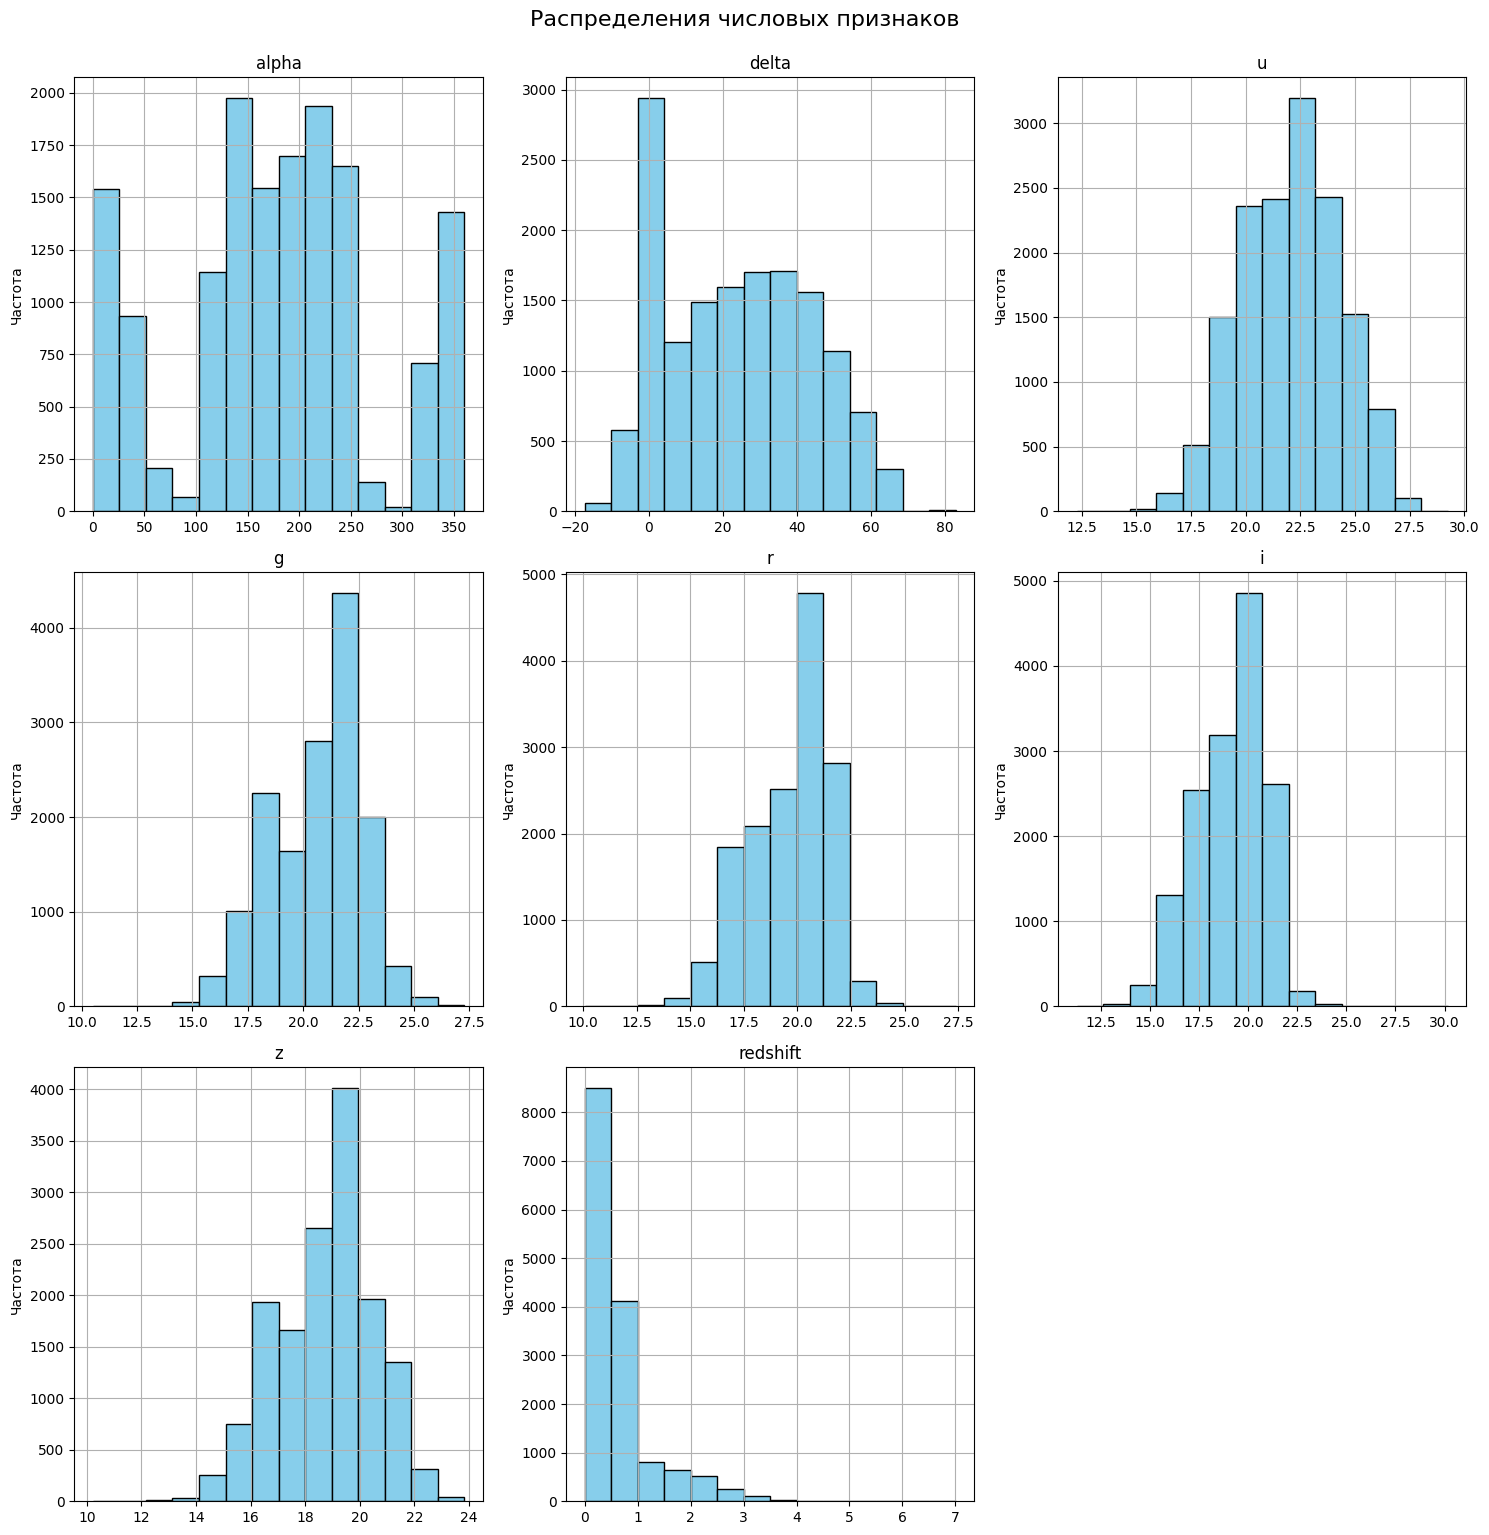

In [28]:
count_intervals = int(1 + math.log2(df.shape[0]))

n_features = len(numeric_columns)
n_subplot_cols = 3
n_subplot_rows = math.ceil(n_features / n_subplot_cols)  
fig, axes = plt.subplots(n_subplot_rows, n_subplot_cols, figsize=(15, 5 * n_subplot_rows))
axes = axes.flatten() if n_subplot_rows > 1 else axes  
for i, col in enumerate(numeric_columns):
    df[col].hist(bins=count_intervals, ax=axes[i], 
                 color='skyblue', edgecolor='black')
    axes[i].set_title(col)  
    axes[i].set_ylabel('Частота')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()

1. alpha <br>
Асимметрия: -0.012 => почти симметрично<br>
Эксцесс: -0.616 => плосковершинное <br>

Распределение близко к равномерному (видно по гистограмме — пики в начале и конце, падение в середине), слабо асимметрично.

2. delta<br>
Мин/макс: -17.28 – 82.95 => несимметричный диапазон<br>
Асимметрия: 0.125 => слабый сдвиг вправо<br>
Эксцесс: -1.099 => очень плоское распределение<br>

Распределение плоское, с небольшим сдвигом вправо. Гистограмма показывает пик в районе 0–20. 

3. u <br>
Асимметрия: 0.012 => почти симметрично<br>
Эксцесс: -0.283 => слегка плоское<br>

Распределение почти симметричное, но с небольшим хвостом в сторону ярких объектов (левый хвост). Гистограмма показывает пик около 22.

4. g<br>
Асимметрия: -0.424 => сильный сдвиг влево<br>
Эксцесс: -0.077 => почти нормальное<br>

Сильно скошено влево — преобладание зеленого фильтра. Мода (16.82) гораздо ниже среднего (20.49), что указывает на наличие большого количества ярких источников. 

5. r<br>
Асимметрия: -0.650 => очень сильный сдвиг влево<br>
Эксцесс: -0.054 => почти нормальное<br>
Мода: 20.55 => близко к медиане<br>

Ещё более выраженный левый хвост, чем у g. 

6. i 
Асимметрия: -0.551 => сильный сдвиг влево<br>
Эксцесс: -0.062 => почти нормальное<br>
Мода: 19.64 => близко к среднему<br>

Похоже на r и g — сильный левый хвост. Гистограмма подтверждает: пик около 20, но есть длинный хвост влево. 

7. z 
Асимметрия: -0.463 => умеренный сдвиг влево<br>
Эксцесс: -0.190 => слегка плоское<br>

Менее скошено, чем r и i. Хвост влево менее выражен. 

8. redshift <br>
Мин/макс: -0.004 – 7.01 => довольно широкий диапазон<br>
Асимметрия: 1.788 => очень сильный сдвиг вправо<br>
Эксцесс: 4.64 => очень островершинное<br>

Распределение сильно скошено вправо, имеет ярко выраженный пик в 0. 

Анализ выбросов: <br>
Наиболее выраженные выбросы наблюдаются в признаке redshift. Остальные признаки (alpha, delta, u, g, r, i, z) имеют более или менее умеренное распределение с небольшими хвостами.

Анализ признаков:<br>

1. redshift — имеет выбросы. <br>
Статистика:<br>
Минимум: -0.004255 (очень близко к 0)<br>
Максимум: 7.011245 — большое значение.<br>
Среднее: 0.573, медиана: 0.418 — значит, среднее смещено вправо из-за "хвоста".<br>
Стандартное отклонение: 0.726 — довольно большое относительно среднего.<br>
Асимметрия: 2.489 — сильная правосторонняя асимметрия. Это говорит о длинном правом хвосте — именно там находятся выбросы.<br>
Эксцесс: 9.719 — очень высокий. Это указывает на то, что распределение имеет тяжёлые хвосты и много значений, отдалённых от центра (выбросов).<br>
Гистограмма: подавляющее большинство объектов имеют redshift близкий к 0 (от 0 до 1), а затем идут редкие объекты с redshift > 2, и один-два с redshift > 6.<br>
Для задачи кластеризации необработанные данные с такими выбросами могут доминировать и искажать результаты, если не обработать.<br>

2. Фотометрические признаки (u, g, r, i, z) <br>
Статистика: Все имеют примерно одинаковый диапазон (около 10–30), средние значения около 19–22, стандартное отклонение около 1.8–2.2.<br>
Асимметрия: Отрицательная (от -0.077 до -0.519), что означает левостороннюю асимметрию — небольшой "хвост" слева (меньшие значения). Это соответствует гистограммам, где пик смещен вправо.<br>
Эксцесс: Близок к 0 или немного отрицательный — распределения близки к нормальным или слегка плосковершинным.<br>
Гистограммы: Распределения достаточно симметричны, с небольшими хвостами слева (особенно заметно в g, r, i). Есть несколько значений в левом хвосте, которые можно считать потенциальными выбросами, но они не так экстремальны, как в redshift.<br>
То есть, небольшие выбросы слева имеются, но они не являются критичными.<br> 

3. Координаты (alpha, delta)<br>
Статистика:<br>
alpha: от 0 до 360, среднее 178, стандартное отклонение 97 — это широкое распределение, но оно ожидаемо для данных, покрывающих всю небесную сферу.<br>
delta: от -17 до 83, среднее 24, стандартное отклонение 19 — также ожидаемо для сканирования SDSS.<br>
Асимметрия: Почти нулевая для alpha, небольшая положительная для delta — распределения почти симметричны.<br>
Эксцесс: Отрицательный — распределения плосковершинные, что часто бывает при равномерном распределении по сфере.<br>
Гистограммы: Распределения выглядят равномерными или слегка неравномерными, без явных выбросов.<br>
Вывод: Выбросов нет. Эти признаки описывают положение объектов на небе, и их распределение естественно широкое.

Обработка признака redshift (имеет выбросы)

count    15000.000000
mean         0.376774
std          0.365513
min         -0.004264
25%          0.049358
50%          0.349517
75%          0.531830
max          2.080846
Name: redshift_log, dtype: float64
Асимметрия:    1.096
Эксцесс:    0.933
Мода: 0.0


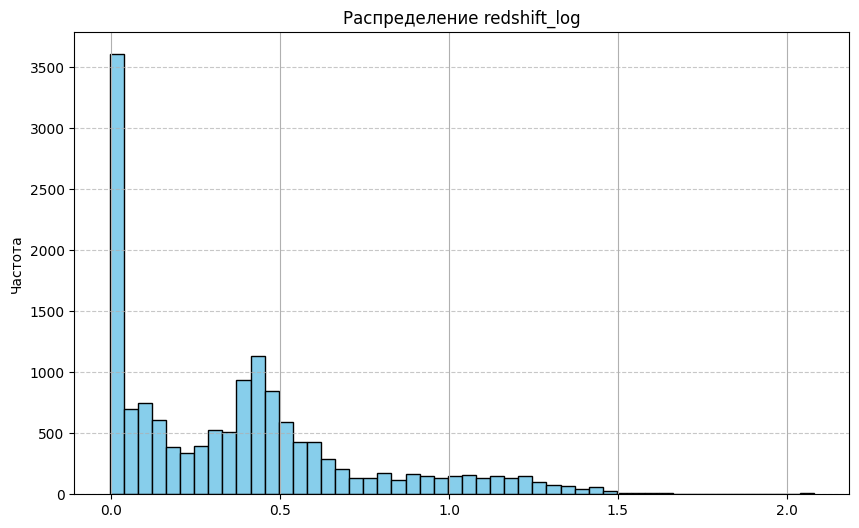

In [ ]:
df['redshift_log'] = np.log1p(df['redshift'])
columns_to_drop = ['redshift']
df = df.drop(columns=columns_to_drop)

print(df['redshift_log'].describe())

skew_val = skew(df['redshift_log'].dropna())
print(f"Асимметрия: {skew_val:8.3f}")
kurt_val = kurtosis(df['redshift_log'].dropna())
print(f"Эксцесс: {kurt_val:8.3f}")
mode_value = df['redshift_log'].mode()
print(f"Мода: {mode_value.iloc[0]}")

df['redshift_log'].hist(bins=50, figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Распределение redshift_log')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.show()

Анализ признака redshift после обработки:<br>

Максимум: 2.08 — значительно меньше, чем 7.01. Это означает, что логарифмирование успешно "сжало" правый хвост. <br>
Асимметрия: 1.096 — уменьшилась более чем вдвое. Распределение стало гораздо менее асимметричным, хотя всё ещё имеет небольшой правосторонний хвост.<br>
Эксцесс: 0.933 — резко уменьшился (было 9.7). Теперь распределение близко к нормальному (экссцесс нормального распределения = 0). Это говорит о том, что "тяжёлые хвосты" почти исчезли.<br>
Гистограмма: Пик около 0 стал ещё более выраженным, но теперь есть заметное возвышение вокруг 0.5–0.6, и хвост идёт плавно до 2.08, без резких скачков или экстремальных значений. Это гораздо более приемлемо для кластеризации распределение.<br>

Логарифмирование (log(1 + redshift)) очень эффективно смягчило влияние выбросов в признаке redshift. Максимальное значение снизилось до 2.08, что делает его сравнимым по масштабу с другими признаками (например, alpha, delta). Сильная правосторонняя асимметрия уменьшилась до умеренной. Эксцесс упал с 9.7 до 0.93, что говорит о том, что распределение стало гораздо ближе к нормальному.

Стандартизация числовых признаков

In [ ]:
X = df

numeric_features = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift_log']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ]
)
X_processed = preprocessor.fit_transform(X)

В ходе лабораторной работы были реализованы различные модели для решения задачи классификации. По итогам оценки всех моделей, лучшую общую производительность на тестовом множестве показали настроенные ("best") модели SVM и Дерево решений, достигнув Accuracy около 95.4% - 96.35% и высоких значений других метрик (Precision, Recall, F1-score, AUC). Также высокие результаты продемонстрировала нейронная сеть с гиперпараметрами по умолчанию (Accuracy 95.6%). Модели GaussianNB и k-NN также показали хорошие, но немного более низкие результаты (около 92% - 88% соответственно). Модель LDA оказалась наименее эффективной среди рассмотренных (Accuracy около 78.45%). Подбор гиперпараметров с помощью GridSearchCV улучшил результаты для большинства моделей, таких как GaussianNB, BernoulliNB, SVM, k-NN и Дерево решений, но не дал положительного эффекта для LDA и, как показал анализ графиков, привёл к переобучению и снижению качества для нейронной сети. 